In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from google.colab import drive

#mount drive
drive.mount('/content/drive')

#change directory
current_directory=os.getcwd()
os.chdir(current_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#available windows
windows=[10, 60, 180, 600]

TCP_FILE_NAME='data_tcp'
UDP_FILE_NAME='data_udp'
ICMP_FILE_NAME='data_icmp'

#features
feature1 = 'ts'
feature2 = 'src_ip'
feature3 = 'src_port'
feature4 = 'dst_ip'
feature5 = 'dst_port'
feature6 = 'pck_len'
feature7 = 'tcp_flags'
feature8 = 'cluster'
feature9 = 'user'
feature10 = 'num_attack'
feature11 = 'first_port_scan'
feature12 = 'ip_diff'
feature13 = 'port_diff'
feature14 = 'range_ip'
feature15 = 'range_port'
feature16 = 'ip_medium'
feature17 = 'ip_std'
feature18 = 'port_medium'
feature19 = 'port_std'
feature20 = 'pck_medium'
feature21 = 'pck_std'

In [3]:
def choose_window(proto):
  print("Choose a time window for", proto)

  user_input=False
  while not (user_input):
    for j in range(0, len(windows)):
      print(str(j+1)+") "+str(windows[j]))

    try:
      user_input = int(input(""))

      if user_input >=1 and user_input <= len(windows):
        window_chosen=windows[user_input-1]
      else:
        print ("\nChoose Well\n")
        user_input=False

    except ValueError:
      print('\nInvalid number!\n')

  return window_chosen

#read data 
def read_data(fname):
  stream = os.popen("find . -name '%s'" % fname)
  fpath = stream.read()[:-1]
  data_original= pd.read_csv(fpath)

  return data_original


#display created clusters
def print_clusters(df, num_cluster=10, title=''):
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
  final_df = pd.concat([principalDf, df[['cluster']]], axis = 1)
  final_df.dropna(inplace=True)
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(title, fontsize = 20)
  targets = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
  colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'darkorange', 'darkblue', 'pink']
  i=1
  for target, color in zip(targets,colors):
      indicesToKeep = final_df['cluster'] == target
      ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
                , final_df.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
      i=i+1
      if i>num_cluster:
        break
  ax.legend(targets)
  ax.grid()


# calculate clusters
def cluster(df, features, _n_clusters=4, _threshold=0.5, _branching_factor=50):
  #rescaling dataset and setting feature
  df_rescaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

  #clusters creation with BIRCH
  brc = Birch(n_clusters=_n_clusters, threshold=_threshold, branching_factor=_branching_factor)

  labels = brc.fit_predict(df_rescaled[features])
  #label assignment 
  df_rescaled['cluster'] = labels

  #calculate clusters' size
  detail = df_rescaled.groupby(['cluster']).size()

  return df_rescaled, labels, detail 


#set optimal cluster parameters
class Cluster_parameters:
    def __init__(self, num_cluster, threshold, branching_factor):
        self.num_cluster = num_cluster
        self.threshold = threshold
        self.branching_factor = branching_factor

# TCP Cluster

In [211]:
#choose time window
tcp_window=choose_window("TCP")

#set file name 
file_tcp=TCP_FILE_NAME+"_"+str(tcp_window)+".csv"

#read data 
data_tcp_original=read_data(file_tcp)

#drop duplicates
data_tcp_rm = data_tcp_original.drop_duplicates(subset=['user'])

Choose a time window for TCP
1) 10
2) 60
3) 180
4) 600
1


In [212]:
tcp_parameters={}

#set parameters 
tcp_parameters[10]=Cluster_parameters(2, 0.95, 3)
tcp_parameters[60]=Cluster_parameters(2, 0.1, 50)
tcp_parameters[180]=Cluster_parameters(4, 0.4, 50)
tcp_parameters[600]=Cluster_parameters(4, 0.35, 50)

In [213]:
#features for clustering
features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  rescaled_data_tcp_rm, tcp_labels, detail=cluster(data_tcp_rm, features, actual_param.num_cluster, actual_param.threshold, actual_param.branching_factor)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_tcp_rm, tcp_labels, detail=cluster(data_tcp_rm, features)

print("TCP cluster's details\n", detail)

TCP cluster's details
 cluster
0      390
1    29397
dtype: int64



*Performance* 



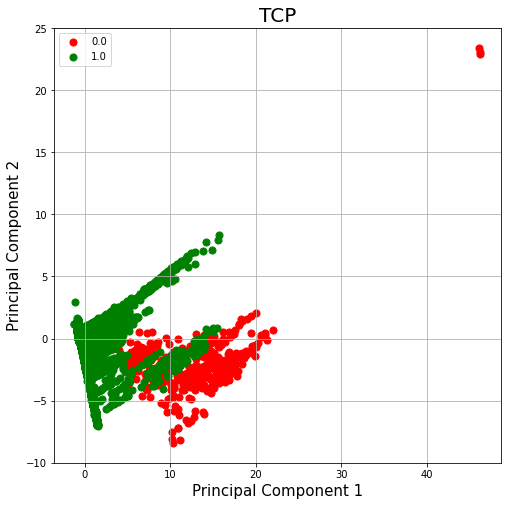

In [214]:
#remove not used data for clustering
rescaled_data_tcp_rm.drop([feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature9], axis = 1,inplace=True)

if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  print_clusters(rescaled_data_tcp_rm, actual_param.num_cluster, "TCP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_tcp_rm)

In [215]:
score_tcp = silhouette_score(rescaled_data_tcp_rm,rescaled_data_tcp_rm['cluster'])
print(score_tcp)

0.7963202736561493


# UDP Cluster

In [265]:
#choose time window
udp_window=choose_window("UDP")

#set file name 
file_udp=UDP_FILE_NAME+"_"+str(udp_window)+".csv"

#read data 
data_udp_original=read_data(file_udp)

#drop duplicates
data_udp_rm = data_udp_original.drop_duplicates(subset=['user'])

Choose a time window for UDP
1) 10
2) 60
3) 180
4) 600
4


In [266]:
udp_parameters={}

#set parameters 
udp_parameters[10]=Cluster_parameters(4, 0.5, 50)  
udp_parameters[60]=Cluster_parameters(4, 0.7, 50)  
udp_parameters[180]=Cluster_parameters(4, 0.1, 50)
udp_parameters[180]=Cluster_parameters(3, 0.1, 50)

In [280]:
#features for clustering
features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  rescaled_data_udp_rm, udp_labels, detail=cluster(data_udp_rm, features, actual_param.num_cluster, actual_param.threshold, actual_param.branching_factor)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_udp_rm, udp_labels, detail=cluster(data_udp_rm, features)

print("UDP cluster's details\n", detail)

There are no algorithm optimizations for this time window. Default parameters are used
UDP cluster's details
 cluster
0      55
1    3516
2      36
dtype: int64


*Performance*

There are no algorithm optimizations for this time window. Default parameters are used


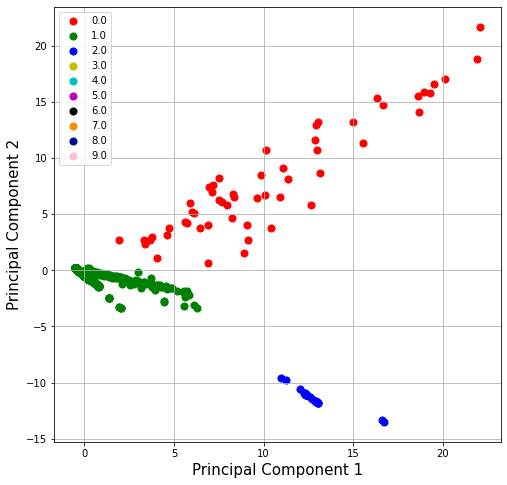

In [278]:
#remove not used data for clustering
rescaled_data_udp_rm.drop([feature1,feature2,feature3,feature4,feature5,feature6,feature9], axis = 1,inplace=True)

#print clusters
if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  print_clusters(rescaled_data_udp_rm, actual_param.num_cluster, "UDP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_udp_rm)

In [279]:
score_udp = silhouette_score(rescaled_data_udp_rm,rescaled_data_udp_rm['cluster'])
print(score_udp)

0.839981951097206


# ICMP Cluster

In [357]:
#choose time window
icmp_window=choose_window("ICMP")

#set file name 
file_icmp=ICMP_FILE_NAME+"_"+str(icmp_window)+".csv"

#read data 
data_icmp_original=read_data(file_icmp)

#drop duplicates
data_icmp_rm = data_icmp_original.drop_duplicates(subset=['user'])

Choose a time window for ICMP
1) 10
2) 60
3) 180
4) 600
4


In [358]:
icmp_parameters={}

#set parameters 
icmp_parameters[10]=Cluster_parameters(10, 0.6, 5)
icmp_parameters[60]=Cluster_parameters(8, 0.1, 10) 
icmp_parameters[60]=Cluster_parameters(8, 0.6, 15)   
icmp_parameters[60]=Cluster_parameters(9, 0.6, 30)

In [372]:
#features for clustering
features=[feature10,feature12,feature14,feature16,feature17,feature20,feature21]

if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  rescaled_data_icmp, icmp_labels, detail=cluster(data_icmp_rm, features, actual_param.num_cluster, actual_param.threshold, actual_param.branching_factor)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_icmp, icmp_labels, detail=cluster(data_icmp_rm, features)

print("ICMP cluster's details\n", detail)

There are no algorithm optimizations for this time window. Default parameters are used
ICMP cluster's details
 cluster
0     4
1     1
2     3
3     9
4    13
5    55
6     2
7     2
8    33
dtype: int64


*Performance*

There are no algorithm optimizations for this time window. Default parameters are used


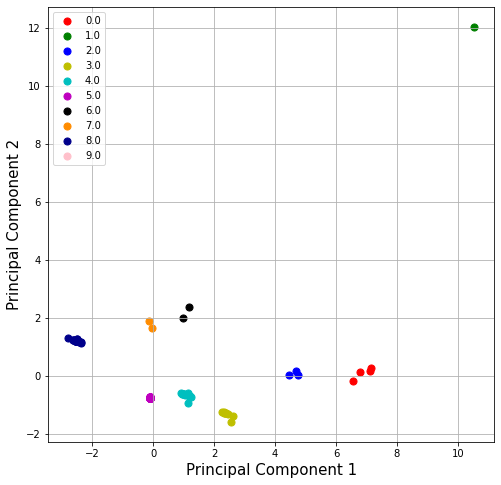

In [373]:
#remove not used data for clustering
rescaled_data_icmp.drop([feature1,feature2,feature4,feature6,feature9], axis = 1,inplace=True)

#print clusters
if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  print_clusters(rescaled_data_icmp, actual_param.num_cluster, "ICMP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_icmp)

In [374]:
score_icmp = silhouette_score(rescaled_data_icmp,rescaled_data_icmp['cluster'])
print(score_icmp)

0.8899482190850367


# Early Classification Performance

In [133]:
def set_original_labels(df_new, df_old, labels):
  df_new['cluster'] = labels
  cluster = []
  map_user = {}
  for index,row in df_new.iterrows():
    map_user[row['user']] = row['cluster']
  for index,row in df_old.iterrows():
    cluster.append(map_user[row['user']])
  cluster_np = np.asarray(cluster)
  cluster = cluster_np.reshape((cluster_np.size,1))
  rescaled_data = pd.DataFrame(StandardScaler().fit_transform(df_old), columns=df_old.columns)
  rescaled_data['cluster'] = cluster 

  return rescaled_data

TCP (original data)

In [ ]:
old_data_tcp = set_original_labels(data_tcp_rm, data_tcp_original, tcp_labels)

#remove artifical features
old_data_tcp.drop([feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)

#evaluating clustering perfomances 
score_tcp = silhouette_score(old_data_tcp,old_data_tcp['cluster'])
print("Score TCP: ", score_tcp)

#print clusters TCP 
if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  print_clusters(old_data_tcp, actual_param.num_cluster, "Original Data TCP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(old_data_tcp)

UDP (original data)

In [ ]:
old_data_udp = set_original_labels(data_udp_rm, data_udp_original, udp_labels)

#remove artifical features
old_data_udp.drop([feature9, feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)

#evaluating clustering perfomances 
score_udp = silhouette_score(old_data_udp,old_data_udp['cluster'])
print("Score UDP: ", score_udp)

#print clusters UDP 
if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  print_clusters(old_data_udp, actual_param.num_cluster, "Original Data UDP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(old_data_udp)

ICMP (original data)

Score ICMP:  0.436664830529453
There are no algorithm optimizations for this time window. Default parameters are used


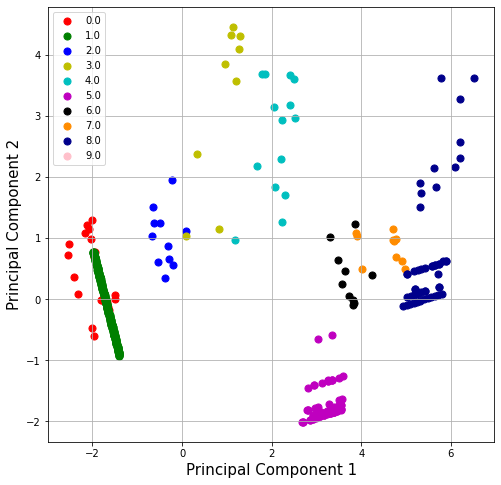

In [375]:
old_data_icmp = set_original_labels(data_icmp_rm, data_icmp_original, icmp_labels)

#remove artifical features
old_data_icmp.drop([feature9,feature10,feature12,feature14,feature16,feature17,feature20,feature21], axis = 1,inplace=True)

#evaluating clustering perfomances 
score_icmp = silhouette_score(old_data_icmp,old_data_icmp['cluster'])
print("Score ICMP: ",score_icmp)

#print clusters ICMP (old data)
if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  print_clusters(old_data_icmp, actual_param.num_cluster, "Original Data ICMP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(old_data_icmp)

First scanned port

In [ ]:
#TCP 

#remove features
rescaled_data_tcp_rm.drop([feature10,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)

#print clusters TCP (fisrt scanned port)
if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  print_clusters(rescaled_data_tcp_rm, actual_param.num_cluster, "First Port TCP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_tcp_rm)

score_tcp = silhouette_score(rescaled_data_tcp_rm,rescaled_data_tcp_rm['cluster'])
print("Score First Port TCP",score_tcp)
print("\n\n")

In [ ]:
#UDP

#remove features
rescaled_data_udp_rm.drop([feature10,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21], axis = 1,inplace=True)

#print clusters UDP (first scanned port)
if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  print_clusters(rescaled_data_udp_rm, actual_param.num_cluster, "First Port UDP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_udp_rm)

score_udp = silhouette_score(rescaled_data_udp_rm,rescaled_data_udp_rm['cluster'])
print("Score First Port UDP",score_udp)
print("\n\n")